In [168]:
%run "part01_preprocessing.ipynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   Unnamed: 8   0 non-null       float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


In [169]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from datetime import datetime


In [170]:
#retornar o a a porcentagem e o valor da porcentagem e forma de texto
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.2f}%\n\n{:d}".format(pct, absolute) 

In [171]:
data.shape

(404289, 9)

In [172]:
def display_stats(df):
    
    """
    Function to display descriptive statistics of numerical variables, includes skewness & kurtosis.   
    """
    
    df=data.describe()
    skewness=data.skew()
    kurtosis=data.kurtosis()
    df=df.append([skewness, kurtosis],ignore_index=True)
    idx=pd.Series(['count','mean','std','min','25%','50%','75%','max','skewness','kurtosis'],name='Summary Statistic')
    df=pd.concat([df,idx],1).set_index('Summary Statistic')
    df=df.drop('count',axis=0)    
    
    cm = sns.light_palette("#A2A2A2", as_cmap = True)
    display(df.style.format('{:.2f}').background_gradient(subset=(df.index[1:],df.columns[:]),cmap=cm))
#     \
#             .highlight_min(axis = 0, color = "#FF6347")\
#             .highlight_max(axis = 0, color = "#2F4F4F"))
   
#display_stats(data)

# Exploratory Data Analysis

In [173]:
data_eda=data.copy()

In [174]:
def get_month(x): 
    
    return dt.datetime(x.year, x.month, 1) 

def get_dates(df, col):
    
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    
    return year, month, day

In [175]:
data_eda["InvoiceMonth"] = data_eda["InvoiceDate"].apply(get_month)
data_eda["CohortMonth"] = data_eda.groupby("CustomerID")["InvoiceMonth"].transform("min")

In [176]:
invoice_year, invoice_month, _ = get_dates(data_eda, "InvoiceMonth")
cohort_year, cohort_month, _ = get_dates(data_eda, "CohortMonth")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

data_eda["CohortIndex"] = 12 * year_diff + month_diff + 1

In [177]:
cohort_data = data_eda.groupby(["CohortMonth","CohortIndex"])["CustomerID"].nunique().reset_index().rename(columns={'CustomerID':'UniqueCustomers'})

#cohort_data = data_eda.groupby(["CohortMonth","CohortIndex"])["CustomerID"].apply(pd.Series.nunique).reset_index()

In [178]:
cohort_pivot = cohort_data.pivot(index = "CohortMonth", columns = "CohortIndex", values = "UniqueCustomers")
cohort_pivot.index = cohort_pivot.index.strftime("%Y-%m")

In [179]:
#zzz=cohort_pivot.iloc[:,0]

In [180]:
cohort_sizes = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_sizes, axis = 0)

In [181]:
#retention.insert(0, 'UniqueCustomer', zzz)

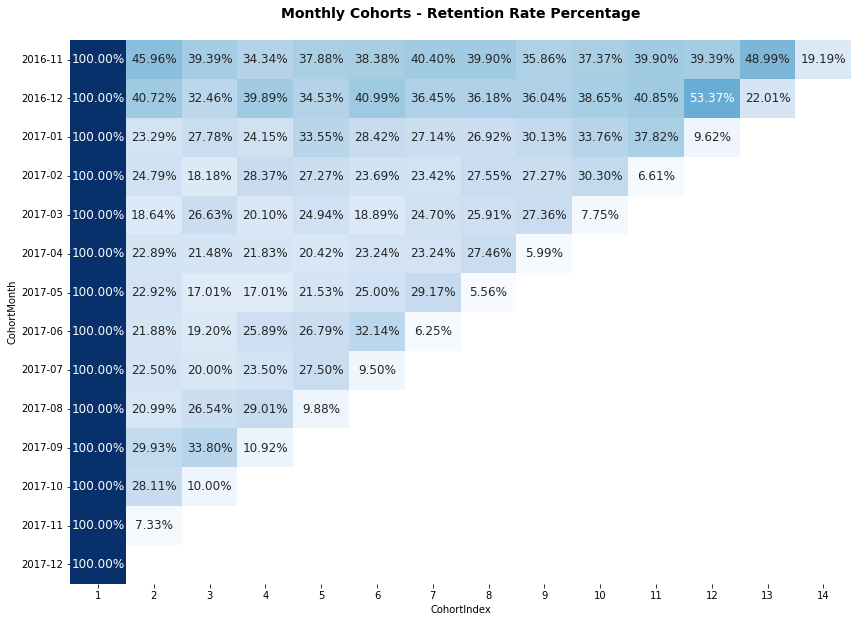

In [182]:
fig, ax = plt.subplots(figsize = (14, 10))
sns.heatmap(retention, cmap = "Blues", annot = True, fmt = ".2%", annot_kws = {"fontsize": 12}, cbar = False, ax = ax)
plt.title("Monthly Cohorts - Retention Rate Percentage\n", fontsize=14, fontweight='bold')
plt.savefig("..//images//cohort_percentage.png")
plt.show()

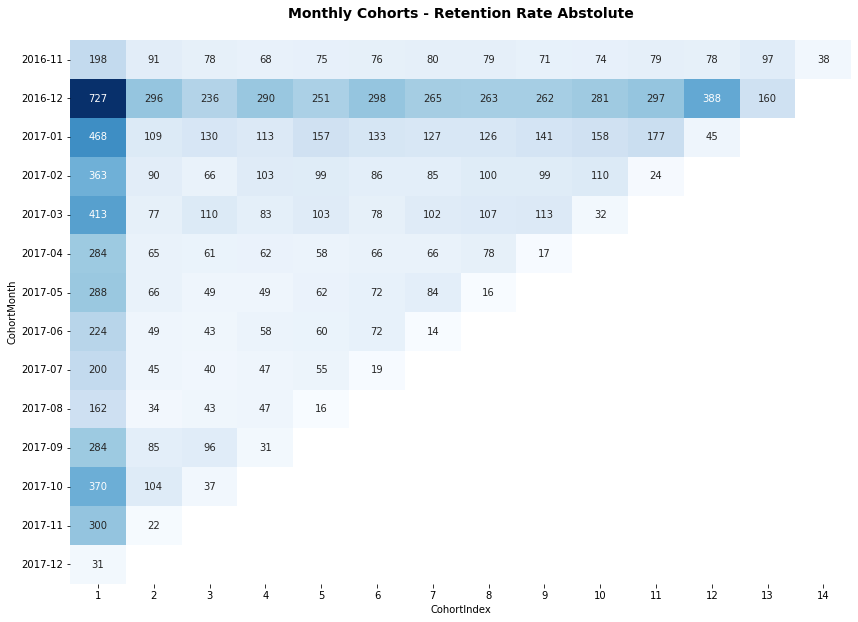

In [183]:
fig, ax = plt.subplots(figsize = (14, 10))
sns.heatmap(cohort_pivot, cmap = "Blues", annot = True, fmt=".0f", cbar = False, ax = ax)
plt.title("Monthly Cohorts - Retention Rate Abstolute\n", fontsize=14, fontweight='bold')
plt.savefig("..//images//cohort_absolute.png")
plt.show()

In [184]:
#Aggregate sum of unique customers  per month from start month to end month order by last month to initial month
customer_per_month = data_eda.groupby("CohortMonth")["CustomerID"].nunique()#.values

#customer_per_month.index= pd.to_datetime(customer_per_month['CohortMonth'])
customer_per_month.index = customer_per_month.index.strftime('%Y/%m')
customers = customer_per_month.cumsum()
customers = customers[::-1]

In [185]:
customer_in_month = data_eda.groupby("CohortIndex")["CustomerID"].nunique()
customer_in_month.index=customer_per_month.index #Inverted

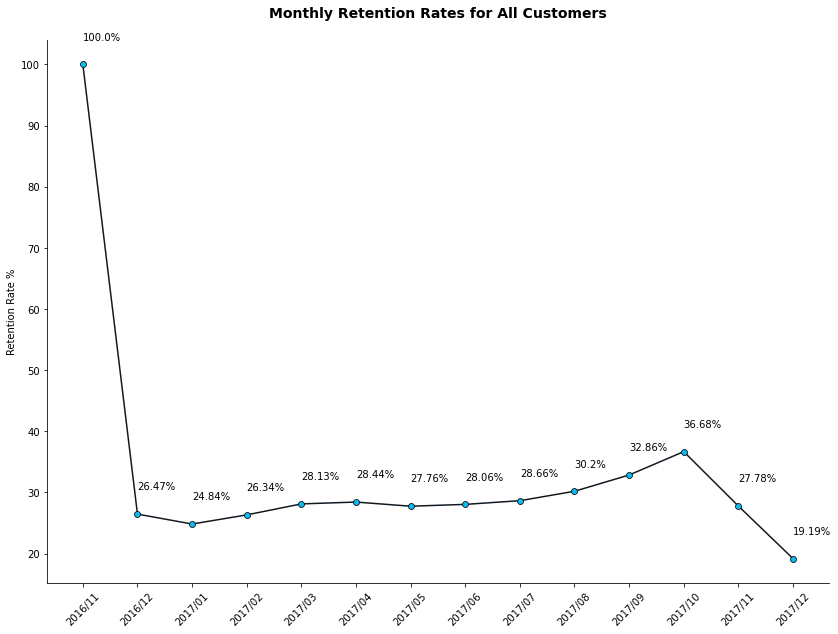

In [186]:
fig, ax = plt.subplots(figsize = (14, 10))
ax.grid(False)
x = customer_in_month.index
y = 100*(customer_in_month / customers.values)

sns.lineplot(x = x, y = y,  color = "#101820", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "black")

for x, y in zip(x, y):
    plt.text(x, y + 4, s = str(round(y, 2)) + "%")

plt.xlabel("")
plt.xticks(rotation=45)
plt.ylabel("Retention Rate %")
plt.title("Monthly Retention Rates for All Customers\n", fontsize=14, fontweight='bold')
sns.despine()
plt.savefig("..//images//cohort_allcustomers.png")
plt.show()

In [187]:
monthly_customer_price_df = data_eda.groupby("InvoiceMonth").agg({"Total": "sum",
                                                               "CustomerID": "nunique"})\
                                                         .rename(columns={'CustomerID':'UniqueCustomers'})

monthly_customer_price_df.index = monthly_customer_price_df.index.strftime('%Y/%m')

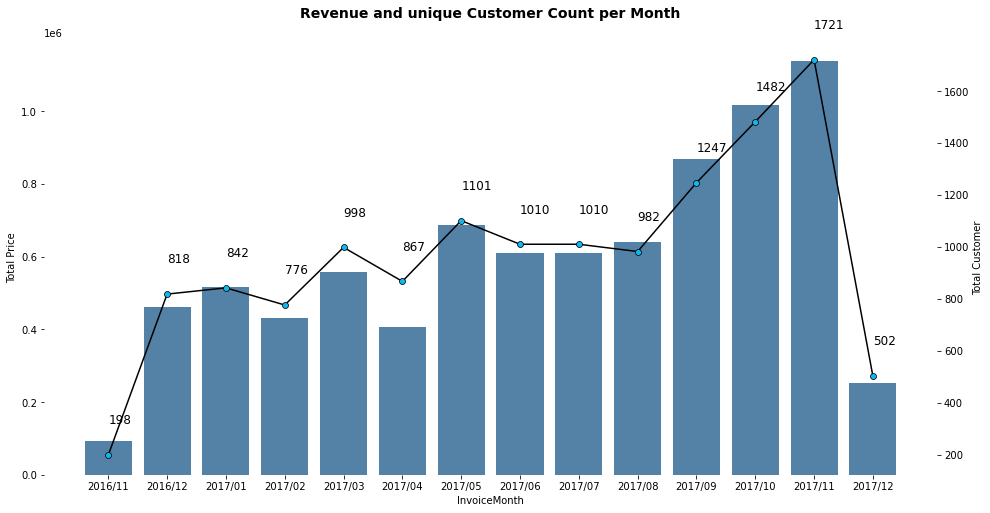

In [188]:
fig, ax = plt.subplots(figsize = (16, 8))

x = monthly_customer_price_df.index
y1 = monthly_customer_price_df.Total
y2 = monthly_customer_price_df.UniqueCustomers


sns.barplot(x = x, y = y1, ax = ax, color = "SteelBlue")
ax2 = ax.twinx()
sns.lineplot(x = x, y = y2, ax = ax2,
            color = "black", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "black")
#ax.set_yticks([])
#ax2.set_yticks([])
ax2.set_ylabel("Total Customer")
ax.set_ylabel("Total Price")
plt.title("Revenue and unique Customer Count per Month\n", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
#ax.text(-0.75, 1000000, "Bars represent revenue \nLine represents unique customer count", fontsize = 10, alpha = 0.8)

for x, y in zip(x,y2):     
     ax2.text(x, y+120, y, fontsize=12)
        
sns.despine(left = True, right = True, bottom = True, top = True)
plt.savefig("..//images//revenue.png")
plt.show()

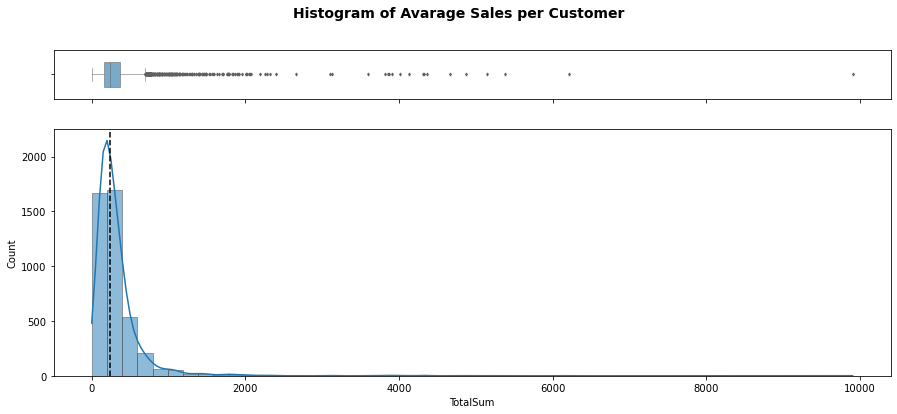

In [97]:
fig, (ax_box, ax_hist) = plt.subplots(2, figsize=(15,6), sharex=True, gridspec_kw = {"height_ratios": (0.2, 1)})
fig.suptitle('Histogram of Avarage Sales per Customer\n', fontsize=14, fontweight='bold')

sns.boxplot(x=sales_per_customer['TotalSum'], 
            ax=ax_box, 
            linewidth=.5, 
            width=.5, 
            palette='Blues_r',
            fliersize=2)
ax_box.set(xlabel='')

sns.histplot(data=sales_per_customer['TotalSum'], 
             ax=ax_hist, 
             bins=50, 
             kde=True, 
             palette='Blues_r',
             edgecolor=".3", 
             linewidth=.5, 
             )

ax_hist.axvline(sales_per_customer['TotalSum'].median(), color='black', ls='--')
#plt.xticks(np.arange(0,2000,50), rotation=45)
#plt.xlim([0,2000])
plt.savefig("..//images//histogram_avarage_sales.png")
plt.show()

In [98]:
zipsorted = sales_per_customer.sort_values(by='TotalSum',ascending=False)
zipsorted['Rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1
zipsorted['TotalSum'] = zipsorted['TotalSum'].round(2)
zipsorted.head(10)
#di.export(zipsorted,'../images/df_rank_sales.png', max_rows=10)

,TotalSum,TotalMean,QuantitySum,UniqueProducts,Rank
CustomerID,,,,,
15098,9904.88,9904.875000,15.250000,1.000000,1
12357,6207.67,47.386794,2708.000000,131.000000,2
15749,5383.98,2169.970833,2253.500000,3.750000,3
12415,5151.59,188.015268,3206.083333,32.250000,4
12688,4873.81,28.501813,3028.000000,171.000000,5
12590,4669.19,68.990896,2139.000000,34.500000,6
12752,4366.78,82.392075,2262.000000,53.000000,7
18102,4327.62,725.878941,1068.733333,7.183333,8
18251,4314.72,269.670000,7824.000000,16.000000,9


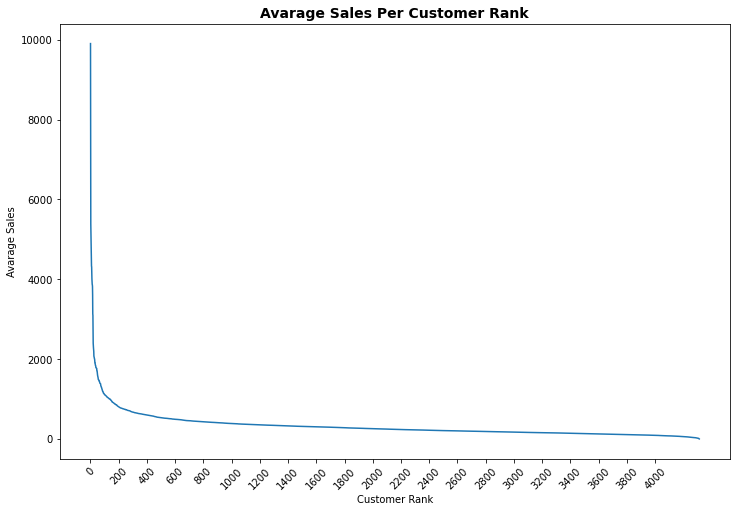

In [99]:
plt.figure(figsize=(12,8))
plt.title('Avarage Sales Per Customer Rank', fontsize=14, fontweight='bold')
sns.lineplot(x='Rank', y='TotalSum', data=zipsorted) 
plt.xlabel('Customer Rank')
plt.ylabel('Avarage Sales') 
plt.xticks(np.arange(0,4200,200), rotation=45)
plt.savefig("..//images//sales_rank.png")
plt.show()

In [100]:
# sum all values of a list and return the percentage and sum
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.2f}%\n\n{:d}".format(pct, absolute) 

In [101]:
country_1=data_eda['Country'].value_counts().iloc[:1]
country_o=data_eda['Country'].value_counts().iloc[1:].sum()

others=pd.Series( data=country_o, index=["Others"], name ="Country") 
country_resume = pd.concat([country_1, others])

In [102]:
print("Total of Countries:", data_eda['Country'].nunique()-1)

Total of Countries: 36


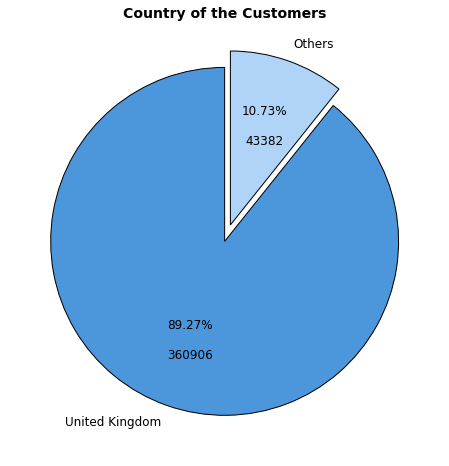

In [103]:
plt.figure(figsize=(12,8))
plt.title('Country of the Customers', fontsize=14, fontweight='bold')

labels = country_resume.index.tolist()
sizes = country_resume.tolist()

plt.pie(sizes, 
        labels=labels, 
        colors=['#4C96DC','#AFD4F8'],
        explode = (0, 0.1), 
        autopct = lambda pct: func(pct, sizes), 
        startangle=90,
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : "black"}, textprops={'fontsize': 12})


plt.savefig("..//images//sales_country.png")
plt.show()

In [104]:
# customer_most_transactions = data.CustomerID.value_counts().sort_values(ascending=False).head(15)

# fig, ax = plt.subplots(figsize = (10, 8))

# sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h", 
#             ax = ax, order = customer_counts.index, palette = "Blues_r")

# plt.title("Customers with most transactions")
# plt.ylabel("CustomerID")
# plt.xlabel("Transaction Count")

In [105]:
temporal = data.copy()

In [106]:
temporal=temporal.set_index(temporal['InvoiceDate']).sort_index(ascending=True)


In [107]:
temporal_d = temporal.resample('D').mean()
temporal_m = temporal.resample('M').mean()
temporal_y = temporal.resample('Y').mean()

In [108]:
x=temporal[['CustomerID','Total','InvoiceNo','InvoiceDate']].groupby('InvoiceDate').agg({'Total':np.sum,
                                                                 'CustomerID':np.unique,
                                                                 'InvoiceNo':np.unique})

ValueError: 'InvoiceDate' is both an index level and a column label, which is ambiguous.

<AxesSubplot:xlabel='InvoiceDate'>

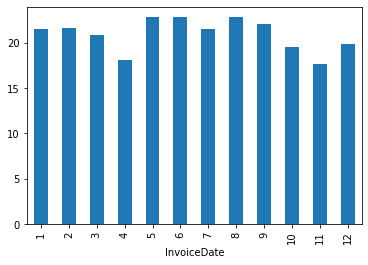

In [109]:
temporal['Total'].groupby(temporal.index.month).mean().plot(kind='bar')

<AxesSubplot:xlabel='day'>

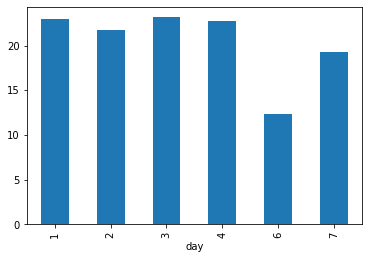

In [110]:
temporal['Total'].groupby(temporal.index.isocalendar().day).mean().plot(kind='bar')

In [111]:
description = data.dropna(subset=['Description'], axis=0)['Description']
description.iloc[220]

'LARGE POPCORN HOLDER '

In [112]:
all_description = " ". join( s for s in description)
print("Total Words: {}".format(len(all_description)))

Total Words: 11221789


In [113]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=2400, height=1800).generate(all_description)

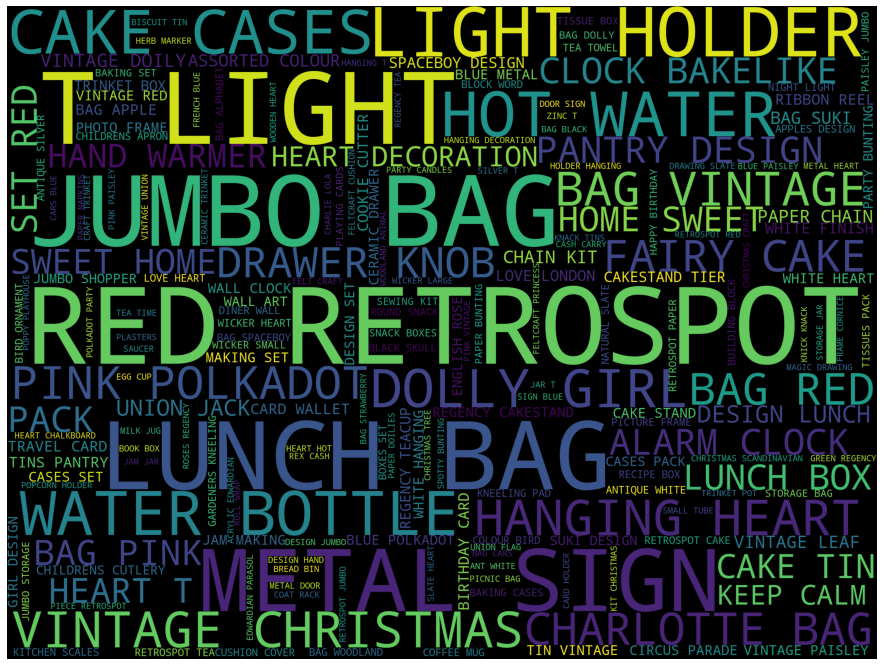

In [114]:
fig,ax = plt.subplots(figsize=(18,12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

In [115]:
df_letter_invoices = data[data['InvoiceNo'].apply(lambda x: bool(regex.search('[^0-9]+',x)))]

print('Total number of invoices with letters: {}.'.format(len(df_letter_invoices)))
print('Total number of negative quantity in invoices with letters: {}.'.format(len(df_letter_invoices[df_letter_invoices['Quantity'] < 0])))

NameError: name 'regex' is not defined

In [ ]:
df_letter_stock = data[data['StockCode'].apply(lambda x: bool(regex.search('[^0-9]+',x)))]

In [ ]:
print('Total number of StockCode with letters: {}.'.format(len(df_letter_stock)))
print('Total number of negative quantity in StockCode with letters: {}.'.format(len(df_letter_stock[df_letter_stock['Quantity'] < 0])))

In [ ]:
list_special_codes = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()

In [ ]:
# list_special_codes = data[data['InvoiceNo'].str.contains('^[a-zA-Z]+', regex=True)]['InvoiceNo'].unique()
# list_special_codes

In [ ]:
# df_letter_invoices["IsCancelled"]=np.where(df_letter_invoices.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
# df_letter_invoices.IsCancelled.value_counts() / df_letter_invoices.shape[0] * 100

In [ ]:
#trash = data[data['StockCode'].apply(lambda x: bool(regex.search('^[a-zA-Z]+$',x)))]['StockCode']#.unique()